In [2]:
# load data files
# execute this cell and choose train.csv and test.csv
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
# imports
import pandas as pd
import io
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_log_error
from math import sqrt, log, exp
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [0]:
# load data into dataframes
train_raw = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8'))).sample(frac=1).reset_index(drop=True)
train_data = train_raw[:1000]
test_data = train_raw[1000:]

In [176]:
# inspect columns
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,506,90,RM,60.0,7596,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,Duplex,2Story,5,5,1952,1952,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,360.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,960,960,GasA,Gd,Y,SBrkr,960,1000,0,1960,0,0,2,0,4,2,TA,10,Typ,0,NaN,Detchd,1952.0,Unf,2,400,TA,TA,N,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2009,COD,Normal,124500
1,590,40,RM,50.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Feedr,1Fam,1Story,5,6,1930,1960,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,742,742,GasA,TA,Y,FuseA,779,0,156,935,0,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1988.0,Unf,1,308,TA,TA,P,0,0,0,0,0,0,NaN,NaN,Shed,600,8,2008,WD,Normal,79500
2,487,20,RL,79.0,10289,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1965,1965,Hip,CompShg,MetalSd,MetalSd,BrkFace,168.0,TA,TA,CBlock,TA,TA,No,ALQ,836,Unf,0,237,1073,GasA,TA,Y,SBrkr,1073,0,0,1073,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,RFn,2,515,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,156000
3,206,20,RL,99.0,11851,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1424,1424,GasA,Ex,Y,SBrkr,1442,0,0,1442,0,0,2,0,3,1,TA,5,Typ,0,NaN,Attchd,1990.0,RFn,2,500,TA,TA,Y,0,34,0,508,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,180500
4,1132,20,RL,63.0,10712,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,5,1991,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Mn,BLQ,212,Unf,0,762,974,GasA,TA,Y,SBrkr,974,0,0,974,0,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,28,0,0,0,0,NaN,MnPrv,NaN,0,9,2007,Oth,Abnorml,93500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1078,20,RL,NaN,15870,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1969,1969,Gable,CompShg,VinylSd,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Mn,BLQ,75,Rec,791,230,1096,GasA,Ex,Y,SBrkr,1096,0,0,1096,1,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1969.0,Fin,1,299,TA,TA,Y,240,32,0,0,0,0,NaN,NaN,NaN,0,3,2006,WD,Abnorml,138800
996,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,5,5,1920,1950,Gable,CompShg,Stucco,Stucco,None,0.0,TA,Fa,BrkTil,TA,TA,No,BLQ,645,Unf,0,270,915,GasA,TA,Y,SBrkr,1167,0,0,1167,0,0,1,0,3,1,TA,6,Maj1,1,Gd,Detchd,1972.0,Unf,2,495,TA,TA,Y,0,0,216,0,126,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
997,89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
998,1329,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,6,7,1920,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,Gd,Gd,BrkTil,Gd,TA,No,LwQ,493,Unf,0,1017,1510,GasW,

In [0]:
# inspect column distributions
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Now analyze features 1 by 1 and decide if they are needed or if any changes are needed

In [0]:
def get_pos_prox_score(x):
  pos = 0
  if(x['Condition1'] == 'PosA'  or x['Condition2'] == 'PosA'):
    pos = 2
  elif(x['Condition1'] == 'PosN'  or x['Condition2'] == 'PosN'):
    pos = 1
  return pos

def get_neg_prox_score(x):
  neg = 0
  if(x['Condition1'] == 'RRAn' or x['Condition1'] == 'RRAe'  or x['Condition2'] == 'RRAn' or x['Condition2'] == 'RRAe'):
    neg = 2
  elif(x['Condition1'] == 'RRNn' or x['Condition1'] == 'RRNe'  or x['Condition2'] == 'RRNn' or x['Condition2'] == 'RRNe'):
    neg = 1
  return neg

def preprocess_data(df):
  train_data = df.copy()
  one_hot_cols = ['MSSubClass', 'Neighborhood', 'RoofStyle', 'RoofMatl', 
                  'BsmtFinType1', 'BsmtFinType2', 'Heating', 'GarageType',
                  'MiscFeature', 'SaleType', 'SaleCondition']
  dropCols = ['Id', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
              'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2',
              'BldgType', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 
              'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
              'BsmtCond', 'BsmtExposure', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
              'Electrical', 'KitchenQual', 'FireplaceQu', 'Functional', 'GarageQual',
              'GarageCond', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence'] 

  le = LabelEncoder()

  # create two new features from MSZoning column
  res_zones = ['FV','RH','RL','RP','RM']
  train_data['ResZoned'] = train_data['MSZoning'].isin(res_zones)
  train_data['Density'] = train_data.apply(lambda x: 4, axis= 1)
  train_data.loc[train_data['MSZoning'].isin(['RL', 'RP', 'A']), 'Density'] = 1
  train_data.loc[train_data['MSZoning'].isin(['RM', 'FV']), 'Density'] = 2
  train_data.loc[train_data['MSZoning'] == 'RH', 'Density'] = 3

  # street just has two possible values
  train_data['RoadType'] = train_data[['Street']].apply(lambda col: le.fit_transform(col))

  # add feature based on has alley, what type probably doesn't matter
  train_data['HasAlley'] = train_data['Alley'].isin(['Grvl','Pave'])

  # ordered feature for lot shape
  oeShape = OrdinalEncoder(categories=[['Reg', 'IR1', 'IR2', 'IR3']])
  train_data['Shape'] = oeShape.fit_transform(train_data[['LotShape']])

  # ordered feature for what utilities are available
  oeUtil = OrdinalEncoder(categories=[['ELO', 'NoSeWa', 'NoSewr', 'AllPub']])
  train_data['Utils'] = oeUtil.fit_transform(train_data[['Utilities']])

  # two new features based on lot_config
  train_data['IsCulDSac'] = train_data['LotConfig'] == 'CulDSac'
  train_data['HasFrontage'] = train_data['LotConfig'].isin(['FR2', 'FR3'])

  # ordered feature for lot slope
  oeSlope = OrdinalEncoder(categories=[['Gtl', 'Mod', 'Sev']])
  train_data['Slope'] = oeSlope.fit_transform(train_data[['LandSlope']])

  # get two new features for proximity
  train_data['PosProxScore'] = train_data.apply(lambda x: get_pos_prox_score(x), axis=1)
  train_data['NegProxScore'] = train_data.apply(lambda x: get_neg_prox_score(x), axis=1)

  # get new feature for building type while fixing incorrect labels
  oeBldg = OrdinalEncoder(categories=[['2FmCon', 'TwnhsI', 'TwnhsE', 'Duplx', '1Fam']])
  train_data.loc[train_data['BldgType'] == '2fmCon', 'BldgType'] = '2FmCon'
  train_data.loc[train_data['BldgType'] == 'Twnhs', 'BldgType'] = 'TwnhsI'
  train_data.loc[train_data['BldgType'] == 'Duplex', 'BldgType'] = 'Duplx'
  train_data['Bldg'] = oeBldg.fit_transform(train_data[['BldgType']])

  # ordered feature for house style
  oeHouse = OrdinalEncoder(categories=[['1Story', '1.5Unf', '1.5Fin', 'SFoyer', 'SLvl', '2Story', '2.5Unf', '2.5Fin']])
  train_data['House'] = oeHouse.fit_transform(train_data[['HouseStyle']])

  # combine dummies across these two columns (also fix incorrect labels)
  ext_dummies = pd.get_dummies(train_data[['Exterior1st', 'Exterior2nd']], {'Exterior1st': 'Ext', 'Exterior2nd': 'Ext2'}, columns=['Exterior1st', 'Exterior2nd'])
  rmvCols = []
  for col in ext_dummies.columns:
    if 'Ext2' in col:
      mat = col.split('_')[1]
      if mat == 'Brk Cmn':
        mat = 'BrkComm'
      if mat == 'CmentBd':
        mat = 'CemntBd'
      if mat == 'Wd Shng':
        mat = 'WdShing'
      extCol = 'Ext_' + mat
      if extCol not in ext_dummies.columns:
        ext_dummies[extCol] = ext_dummies[col]
      ext_dummies[extCol] = ext_dummies[extCol] | ext_dummies[col]
      rmvCols.append(col)
  ext_dummies.drop(rmvCols, axis=1, inplace=True)
  train_data = pd.concat([train_data, ext_dummies], axis=1)

  # ordered column for masonry
  train_data.loc[train_data['MasVnrType'].isna(), 'MasVnrType'] = 'None'
  oeMasonry = OrdinalEncoder(categories=[['CBlock', 'None', 'BrkCmn', 'BrkFace', 'Stone']])
  train_data['Masonry'] = oeMasonry.fit_transform(train_data[['MasVnrType']])

  # ordered features for exterior qualit/condition
  oeExtQ = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['ExtQual'] = oeExtQ.fit_transform(train_data[['ExterQual']])
  train_data['ExtCond'] = oeExtQ.fit_transform(train_data[['ExterCond']])

  # ordered feature for foundation by mean of SalePrice distribution
  oeFound = OrdinalEncoder(categories=[['Slab', 'BrkTil', 'CBlock', 'Stone', 'Wood', 'PConc']])
  train_data['FoundationMat'] = oeFound.fit_transform(train_data[['Foundation']])

  # ordered features for basement quality and condition
  train_data.loc[train_data['BsmtQual'].isna(), 'BsmtQual'] = 'NA'
  train_data.loc[train_data['BsmtCond'].isna(), 'BsmtCond'] = 'NA'
  oeBsmtQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['BsmtQ'] = oeBsmtQ.fit_transform(train_data[['BsmtQual']])
  train_data['BsmtC'] = oeBsmtQ.fit_transform(train_data[['BsmtCond']])

  # ordered feature for basement exposure
  train_data.loc[train_data['BsmtExposure'].isna(), 'BsmtExposure'] = 'NA'
  oeBsmtExp = OrdinalEncoder(categories=[['NA', 'No', 'Mn', 'Av', 'Gd']])
  train_data['BsmtExp'] = oeBsmtExp.fit_transform(train_data[['BsmtExposure']])

  # add feature for finished bsmt area, also keep unfinished area
  train_data['FinBsmtArea'] = train_data['TotalBsmtSF'] - train_data['BsmtUnfSF']

  # ordered feature for heating quality
  oeHeat = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['HeatingQual'] = oeHeat.fit_transform(train_data[['HeatingQC']])

  # only two values for central air
  train_data['CentrlAir'] = train_data[['CentralAir']].apply(lambda col: le.fit_transform(col))

  # ordered feature for fuse types
  train_data.loc[train_data['Electrical'].isna(), 'Electrical'] = 'NA'
  oeElec = OrdinalEncoder(categories=[['NA', 'FuseP', 'FuseF', 'Mix', 'FuseA', 'SBrkr']])
  train_data['Elec'] = oeElec.fit_transform(train_data[['Electrical']])

  # ordered feature for kitchen quality
  oeKitch = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['KitchQual'] = oeKitch.fit_transform(train_data[['KitchenQual']])

  # ordered feature for home functionality
  oeFunc = OrdinalEncoder(categories=[['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']])
  train_data['HomeFunct'] = oeFunc.fit_transform(train_data[['Functional']])

  # ordered feature for fireplace quality
  train_data.loc[train_data['FireplaceQu'].isna(), 'FireplaceQu'] = 'NA'
  oeFireQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['FireplQual'] = oeFireQ.fit_transform(train_data[['FireplaceQu']])

  # ordered features for garage quality and condition
  train_data.loc[train_data['GarageQual'].isna(), 'GarageQual'] = 'NA'
  train_data.loc[train_data['GarageCond'].isna(), 'GarageCond'] = 'NA'
  oeGarage = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['GarageQ'] = oeGarage.fit_transform(train_data[['GarageQual']])
  train_data['GarageC'] = oeGarage.fit_transform(train_data[['GarageCond']])

  # ordered feature for garage finish
  train_data.loc[train_data['GarageFinish'].isna(), 'GarageFinish'] = 'NA'
  oeGarageFin = OrdinalEncoder(categories=[['NA', 'Unf', 'RFn', 'Fin']])
  train_data['GarageFin'] = oeGarageFin.fit_transform(train_data[['GarageFinish']])

  # ordered feature for paved driveway
  oeDrive = OrdinalEncoder(categories=[['N', 'P', 'Y']])
  train_data['Driveway'] = oeDrive.fit_transform(train_data[['PavedDrive']])

  # ordered feature for pool quality
  train_data.loc[train_data['PoolQC'].isna(), 'PoolQC'] = 'NA'
  oePool = OrdinalEncoder(categories=[['NA', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['PoolQual'] = oePool.fit_transform(train_data[['PoolQC']])

  # ordered feature for fence
  train_data.loc[train_data['Fence'].isna(), 'Fence'] = 'NA'
  oeFence = OrdinalEncoder(categories=[['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])
  train_data['FenceQual'] = oeFence.fit_transform(train_data[['Fence']])

  # fix NAs in numeric columns
  train_data.loc[train_data['MasVnrArea'].isna(), 'MasVnrArea'] = 0
  train_data.loc[train_data['LotFrontage'].isna(), 'LotFrontage'] = 0
  train_data.loc[train_data['GarageYrBlt'].isna(), 'GarageYrBlt'] = train_data.loc[train_data['GarageYrBlt'].isna(), 'YearBuilt']

  # one-hot encode columns with no obvious ordering
  train_data = pd.get_dummies(train_data, columns=one_hot_cols)

  # drop categorical features that we've extracted
  train_data.drop(dropCols, axis=1, inplace=True)

  return train_data

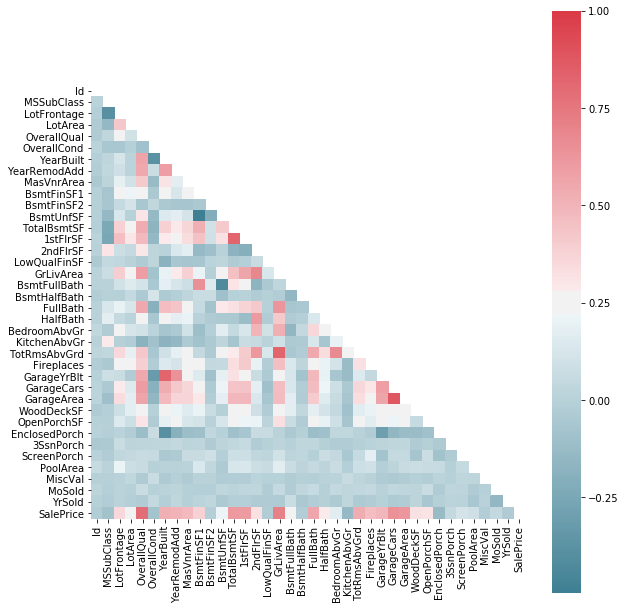

In [0]:
# make heatmap of correllations
corr = train_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9, 9))
cmap = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, ax=ax,  square=True)
fig.tight_layout()

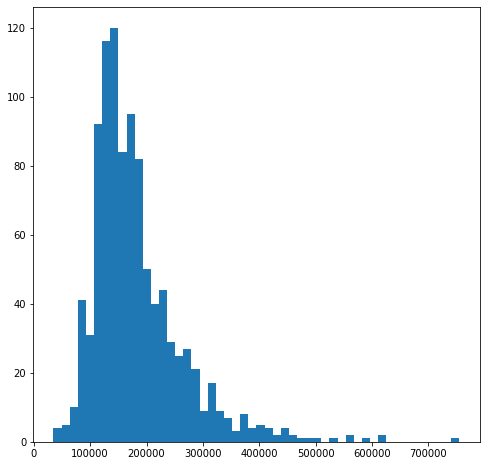

In [279]:
# histogram of target to check for major outliers or strange distributions
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.hist(train_data['SalePrice'], bins=50)
fig.show()

In [0]:
def fix_cols(df_train, df_test):
  new_test = df_test.copy()
  for col in new_test.columns:
    if col not in df_train.columns:
      new_test.drop(col, axis=1, inplace=True)
  for col in df_train:
    if col not in new_test.columns:
      new_test[col] = 0
  return new_test

def get_error(y_true, y_pred):
  y_new = y_true[y_pred > 0]
  y_pred_new = y_pred[y_pred > 0]
  return sqrt(mean_squared_log_error(y_new, y_pred_new))


In [0]:
processed = preprocess_data(train_data)
processed_test = preprocess_data(test_data)
processed_test = fix_cols(processed, processed_test)

In [0]:
results = []

In [286]:
# dumb linear model with all features converting all categorical variables to simple dummies
dummies = pd.get_dummies(train_data).dropna()
X = dummies.drop(['SalePrice', 'Id'], axis=1)
y = dummies['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
dummies_test = pd.get_dummies(test_data).dropna()
dummies_test = fix_cols(dummies, dummies_test)
X_test = dummies_test.drop(['SalePrice', 'Id'], axis=1)
y_pred = lm.predict(X_test)
err = get_error(dummies_test['SalePrice'], y_pred)
print(err)
results.append(['dummy linear', err])
results

1.0197956030097715


[['dummy linear', 1.0197956030097715]]

In [287]:
X = processed.drop(['SalePrice'], axis=1)
y = processed['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred = lm.predict(X_test)
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['processed linear', err])

0.9549865393227729


[['dummy linear', 1.0197956030097715],
 ['processed linear', 0.9549865393227729]]

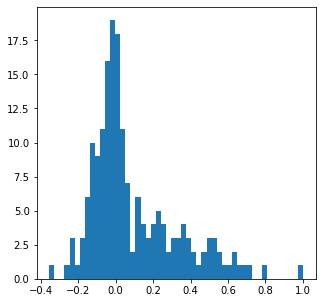

In [22]:
# inspect correlations of new features
corr = processed.corr()
corr['SalePrice']
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(corr['SalePrice'], bins = 50)
fig.show()

In [289]:
# try choosing features based on corr coeficients with SalePrice
colsToUse = corr.index[(corr['SalePrice'] > 0.2) | (corr['SalePrice'] < -0.2)].tolist()
X = processed[colsToUse].drop(['SalePrice'], axis=1)
y = processed['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
X_test = processed_test[colsToUse].drop(['SalePrice'], axis=1)
y_pred = lm.predict(X_test)
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['linear corr cols', err])

0.17411364597318915


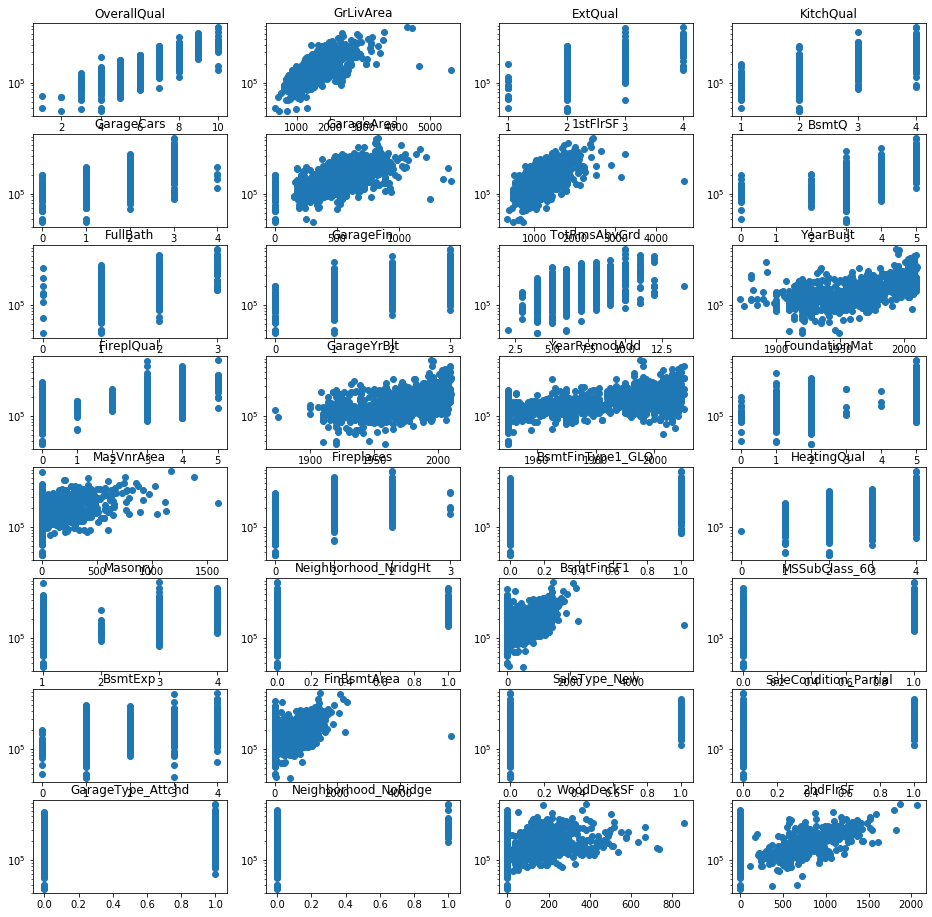

In [158]:
# visualize features with highest correllations
num_cols = 32
topcorrs = corr[['SalePrice']].sort_values('SalePrice', ascending=False).index[1:num_cols+1]

fig = plt.figure(figsize=(16,16))
for idx,col in enumerate(topcorrs, start=1):
  ax = fig.add_subplot(8,4,idx)
  ax.scatter(processed[col], processed['SalePrice'])
  plt.yscale('log') # added after the fact because plots had larger dispersion at high SalePrice
  ax.set_title(col)
fig.show()

After looking at the plots above, from here on we predict to log(SalePrice) in our linear models.

In [245]:
# choose features based manually based on scatter plots
colsToUse_scatter = ['OverallQual', 'GrLivArea', 'ExtQual', 'KitchQual', 'GarageArea', 
             '1stFlrSF', 'BsmtQ', 'FullBath', 'GarageFin', 'TotRmsAbvGrd', 
             'YearRemodAdd', 'MasVnrArea', 'FinBsmtArea', 
             'Neighborhood_NridgHt', 'Neighborhood_NoRidge', 'WoodDeckSF', 
             '2ndFlrSF']
X = processed[colsToUse_scatter]
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test[colsToUse_scatter]
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['scatter visual linear (vs log(SP))', err])

0.15805735963883197


In [246]:
# manually choose features based on intuition
colsToUse_intuit = ['LotArea','OverallQual','OverallCond','YearRemodAdd','1stFlrSF',
 '2ndFlrSF','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
 'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
 'PoolArea','Utils','PosProxScore','NegProxScore','ExtQual','ExtCond','BsmtQ',
 'BsmtC','HeatingQual','CentrlAir','Elec','KitchQual','HomeFunct','FireplQual',
 'GarageQ','GarageC','Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale',
 'Neighborhood_BrkSide','Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor',
 'Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV',
 'Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NPkVill','Neighborhood_NWAmes',
 'Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown','Neighborhood_SWISU',
 'Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker',
 ]
X = processed[colsToUse_intuit]
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test[colsToUse_intuit]
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['intuitive linear (vs log(SP))', err])

0.1450300909718789


In [0]:
def get_expvar_by_ncomp(pca):
  total_exp_var = 0.0
  points = np.empty([pca.n_components_, 2])
  for (i, var) in enumerate(pca.explained_variance_ratio_):
    total_exp_var += var
    points[i,0] = i
    points[i,1] = total_exp_var
  return points


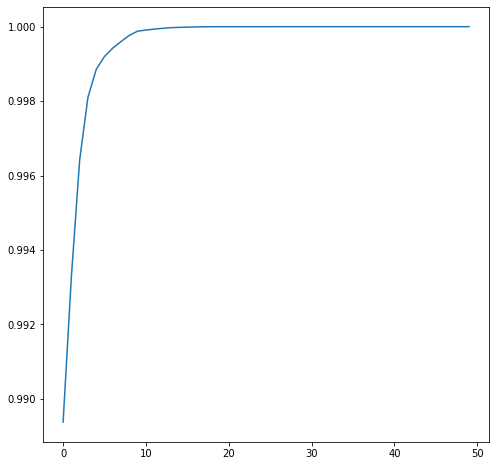

In [210]:
# try PCA with different values of n_components
pca = PCA(n_components=50)
pca.fit(processed.drop(['SalePrice'], axis=1))
points = get_expvar_by_ncomp(pca)
x, y = points.T

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, y)
fig.show()

In [240]:
# use PCA to reduce feature space dramatically
pca = PCA(n_components=21)
X = pca.fit_transform(processed.drop(['SalePrice'], axis=1))
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = pca.transform(processed_test.drop(['SalePrice'], axis=1))
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['pca (vs log(SP))', err])

0.1959401716412722


In [239]:
# PCA error increases dramatically at the 22nd component and above, why is that?
pca = PCA(n_components=50)
X = pca.fit_transform(processed.drop(['SalePrice'], axis=1))
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = pca.transform(processed_test.drop(['SalePrice'], axis=1))
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['bad pca (vs log(SP))', err])

13.78218552172064


In [244]:
# Support Vector Regression
svr = SVR(gamma='scale')
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
svr.fit(X, y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = svr.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['SVR (vs log(SP))', err])

0.22356935808252182


In [257]:
# lasso 
lasso = Lasso(alpha=0.01, max_iter=100000)
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lasso.fit(X,y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = lasso.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['Lasso (vs log(SP))', err])

0.17506676042176045


In [267]:
# lasso with model selection
lasso = LassoCV(cv=10, alphas=np.array([n/1000.0 for n in range(1,100,1)]), max_iter=100000)
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lasso.fit(X,y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = lasso.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['LassoCV (vs log(SP))', err])

4.047086442025843


In [271]:
# neural net on preprocessed features
net = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=10000)
X = processed.drop(['SalePrice'], axis=1)
y = processed['SalePrice']
net.fit(X, y)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred = net.predict(X_test)
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['neural net preprocessed', err])

0.23450849408815608


In [272]:
# neural net on simple one-hot features
net = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=10000)
dummies = pd.get_dummies(train_data).dropna()
X = dummies.drop(['SalePrice', 'Id'], axis=1)
y = dummies['SalePrice']
net.fit(X,y)
dummies_test = pd.get_dummies(test_data).dropna()
dummies_test = fix_cols(dummies, dummies_test)
X_test = dummies_test.drop(['SalePrice', 'Id'], axis=1)
y_pred = net.predict(X_test)
err = get_error(dummies_test['SalePrice'], y_pred)
print(err)
results.append(['neural net one-hot encoded', err])

0.2140096492978097


In [273]:
# regression on log(SalePrice) with all dummies
dummies = pd.get_dummies(train_data).dropna()
X = dummies.drop(['SalePrice', 'Id'], axis=1)
y = dummies[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
dummies_test = pd.get_dummies(test_data).dropna()
dummies_test = fix_cols(dummies, dummies_test)
X_test = dummies_test.drop(['SalePrice', 'Id'], axis=1)
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
err = get_error(dummies_test['SalePrice'], y_pred)
print(err)
results.append(['dummy linear (vs log(SP))', err])

0.7423239605054586


In [280]:
# regression on log(SalePrice) with all preprocessed feats
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['processed linear (vs log(SP))', err])

10.546376827571148


In [290]:
pd.DataFrame(results, columns=['Method', 'MeanSquaredLogError'])

,Method,MeanSquaredLogError
0,dummy linear,1.019796
1,processed linear,0.954987
2,processed linear,0.174114
3,linear corr cols,0.174114


From the above analysis we notice a few key things to point out:


*   The algorithm with the best accuracy is the intuitive linear regression model
*   Simple One-Hot Encoding works very well
*   Simple LinearRegression models work better than more complex ones like Neural Networks in many cases (especially when you don't have the time to do the necessary fine tuning neural networks require)
*   Best to have domain knowledge
*   "Black Box" Algorithms are hard to debug
*   Large feature spaces are hard to debug and could decrease accuracy




Below is my original step by step analysis/processing of each feature. This has since been modified and added to the preprocess_data function but is kept here for reference.

In [0]:
# drop Id column it shouldn't matter
train_data.drop('Id', axis=1, inplace=True)

In [0]:
# MSSubClass is an int but it really represents a set of categories
# the information in the categories is mostly contained in other features so let's drop it
train_data.drop('MSSubClass', axis=1, inplace=True)

In [0]:
train_data['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [0]:
res_zones = ['FV','RH','RL','RP','RM']
train_data['ResZoned'] = train_data['MSZoning'].isin(res_zones)
train_data['Density'] = train_data.apply(lambda x: 4, axis= 1)
train_data.loc[train_data['MSZoning'].isin(['RL', 'RP', 'A']), 'Density'] = 1
train_data.loc[train_data['MSZoning'].isin(['RM', 'FV']), 'Density'] = 2
train_data.loc[train_data['MSZoning'] == 'RH', 'Density'] = 3

In [0]:
train_data.drop('MSZoning', axis=1, inplace=True)

In [0]:
le = LabelEncoder()

In [0]:
train_data['RoadType'] = train_data[['Street']].apply(lambda col: le.fit_transform(col))

In [0]:
train_data.drop('Street', axis=1, inplace=True)

In [0]:
train_data['HasAlley'] = train_data['Alley'].isin(['Grvl','Pave'])

In [0]:
train_data.drop('Alley', axis=1, inplace=True)

In [0]:
oeShape = OrdinalEncoder(categories=[['Reg', 'IR1', 'IR2', 'IR3']])
train_data['Shape'] = oeShape.fit_transform(train_data[['LotShape']])

In [0]:
train_data.drop('LotShape', axis=1, inplace=True)

In [0]:
train_data.drop('LandContour', axis=1, inplace=True)

In [0]:
oeUtil = OrdinalEncoder(categories=[['ELO', 'NoSeWa', 'NoSewr', 'AllPub']])
train_data['Utils'] = oeUtil.fit_transform(train_data[['Utilities']])

In [0]:
train_data.drop('Utilities', axis=1, inplace=True)

In [0]:
train_data['IsCulDSac'] = train_data['LotConfig'] == 'CulDSac'
train_data['HasFrontage'] = train_data['LotConfig'].isin(['FR2', 'FR3'])

In [0]:
train_data.drop('LotConfig', axis=1, inplace=True)

In [0]:
oeSlope = OrdinalEncoder(categories=[['Gtl', 'Mod', 'Sev']])
train_data['Slope'] = oeSlope.fit_transform(train_data[['LandSlope']])

In [0]:
train_data.drop('LandSlope', axis=1, inplace=True)

In [0]:
train_data = pd.concat([train_data, pd.get_dummies(train_data['Neighborhood'])], axis=1)

In [0]:
train_data.drop('Neighborhood', axis=1, inplace=True)

In [0]:
def get_prox_num(x):
  pos = 0
  neg = 0
  if(x['Condition1'] == 'RRAn' or x['Condition1'] == 'RRAe'  or x['Condition2'] == 'RRAn' or x['Condition2'] == 'RRAe'):
    neg = -2
  elif(x['Condition1'] == 'RRNn' or x['Condition1'] == 'RRNe'  or x['Condition2'] == 'RRNn' or x['Condition2'] == 'RRNe'):
    neg = -1
  
  if(x['Condition1'] == 'PosA'  or x['Condition2'] == 'PosA'):
    pos = 2
  elif(x['Condition1'] == 'PosN'  or x['Condition2'] == 'PosN'):
    pos = 1

  return pos + neg

In [0]:
train_data['ProximityScore'] = train_data.apply(lambda x: get_prox_num(x), axis=1)

In [0]:
train_data.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

In [0]:

oeBldg = OrdinalEncoder(categories=[['2FmCon', 'TwnhsI', 'TwnhsE', 'Duplx', '1Fam']])
train_data.loc[train_data['BldgType'] == '2fmCon', 'BldgType'] = '2FmCon'
train_data.loc[train_data['BldgType'] == 'Twnhs', 'BldgType'] = 'TwnhsI'
train_data.loc[train_data['BldgType'] == 'Duplex', 'BldgType'] = 'Duplx'
train_data['Bldg'] = oeBldg.fit_transform(train_data[['BldgType']])

In [0]:
train_data.drop('BldgType', axis=1, inplace=True)

In [0]:
oeHouse = OrdinalEncoder(categories=[['1Story', '1.5Unf', '1.5Fin', 'SFoyer', 'SLvl', '2Story', '2.5Unf', '2.5Fin']])
train_data['House'] = oeHouse.fit_transform(train_data[['HouseStyle']])

In [0]:
train_data.drop('HouseStyle', axis=1, inplace=True)

In [0]:
print(train_data['YearBuilt'].min())
print(train_data['YearRemodAdd'].min())
print(train_data['YearBuilt'].max())
print(train_data['YearRemodAdd'].max())

1872
1950
2010
2010


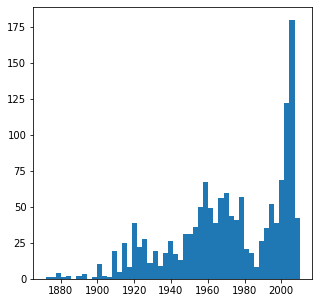

In [0]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(train_data['YearBuilt'], bins = 50)
fig.show()

In [0]:
train_data.drop('RoofStyle', axis=1, inplace=True)

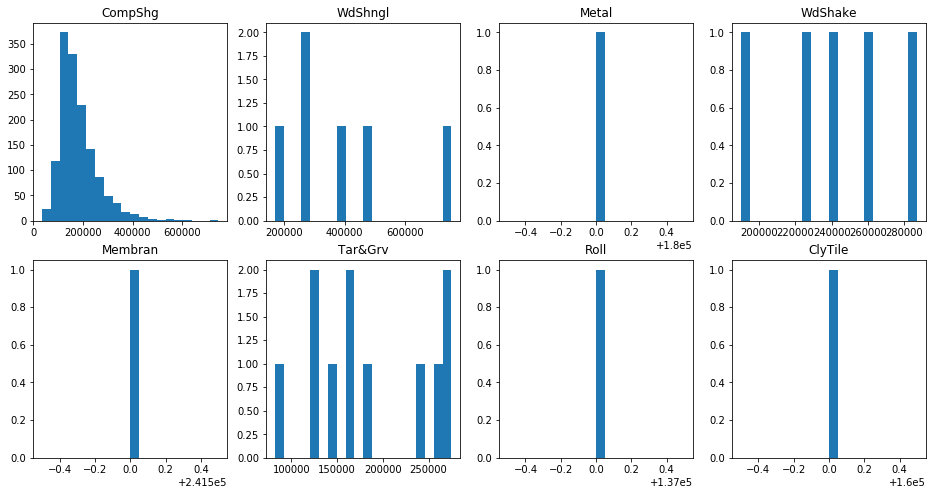

In [0]:
fig = plt.figure(figsize=(16,8))
mats = train_data['RoofMatl'].unique()
for idx,mat in enumerate(mats, start=1):
  ax = fig.add_subplot(2,4,idx)
  ax.hist(train_data.loc[train_data['RoofMatl'] == mat, 'SalePrice'], bins = 20)
  ax.set_title(mat)
fig.show()

In [0]:
print(len(train_data.loc[train_data['RoofMatl'] == 'Metal']))
print(len(train_data.loc[train_data['RoofMatl'] == 'Membran']))
print(len(train_data.loc[train_data['RoofMatl'] == 'Roll']))
print(len(train_data.loc[train_data['RoofMatl'] == 'ClyTile']))

1
1
1
1


In [0]:
# not enough distribution on the values besides CompShg
train_data.drop('RoofMatl', axis=1, inplace=True)

In [0]:
ext_dummies = pd.get_dummies(train_data[['Exterior1st', 'Exterior2nd']], {'Exterior1st': 'Ext', 'Exterior2nd': 'Ext2'}, columns=['Exterior1st', 'Exterior2nd'])

rmvCols = []
for col in ext_dummies.columns:
  if 'Ext2' in col:
    mat = col.split('_')[1]
    if mat == 'Brk Cmn':
      mat = 'BrkComm'
    if mat == 'CmentBd':
      mat = 'CemntBd'
    if mat == 'Wd Shng':
      mat = 'WdShing'
    extCol = 'Ext_' + mat
    if extCol not in ext_dummies.columns:
      ext_dummies[extCol] = ext_dummies[col]
    ext_dummies[extCol] = ext_dummies[extCol] | ext_dummies[col]
    rmvCols.append(col)
ext_dummies.drop(rmvCols, axis=1, inplace=True)

train_data = pd.concat([train_data, ext_dummies], axis=1)

In [0]:
train_data.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

In [0]:
train_data.loc[train_data['MasVnrType'].isna(), 'MasVnrType'] = 'None'
oeMasonry = OrdinalEncoder(categories=[['CBlock', 'None', 'BrkCmn', 'BrkFace', 'Stone']])
train_data['Masonry'] = oeMasonry.fit_transform(train_data[['MasVnrType']])

In [0]:
train_data.drop('MasVnrType', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['MasVnrArea'].isna(), 'MasVnrArea'] = 0

In [0]:
oeExtQ = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['ExtQual'] = oeExtQ.fit_transform(train_data[['ExterQual']])
train_data['ExtCond'] = oeExtQ.fit_transform(train_data[['ExterCond']])

In [0]:
train_data.drop(['ExterQual', 'ExterCond'], axis=1, inplace=True)

PConc mean= 225230.44204018547
CBlock mean= 149805.714511041
BrkTil mean= 132291.07534246575
Wood mean= 185666.66666666666
Slab mean= 107365.625
Stone mean= 165959.16666666666


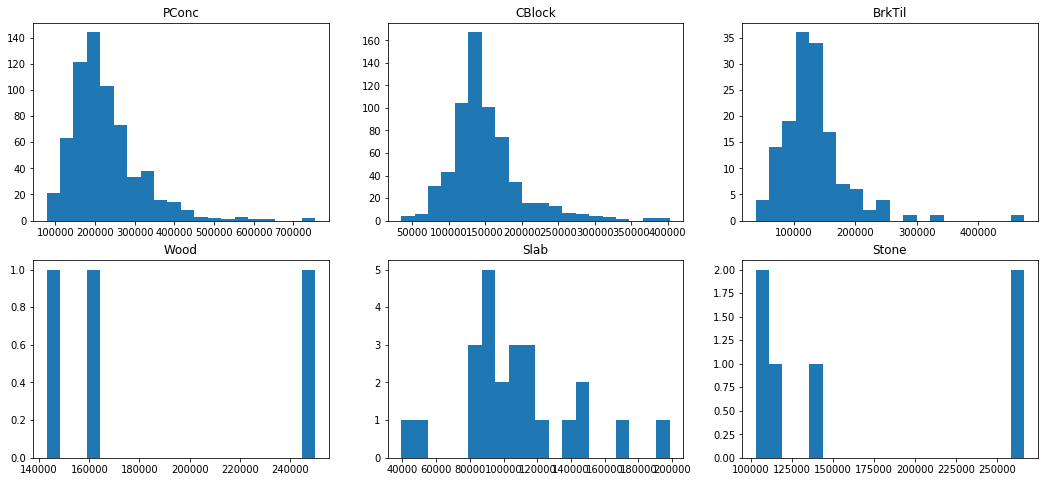

In [0]:
fig = plt.figure(figsize=(18,8))
mats = train_data['Foundation'].unique()
for idx,mat in enumerate(mats, start=1):
  ax = fig.add_subplot(2,3,idx)
  ax.hist(train_data.loc[train_data['Foundation'] == mat, 'SalePrice'], bins = 20)
  ax.set_title(mat)
  print(mat + ' mean= ' + str(train_data.loc[train_data['Foundation'] == mat, 'SalePrice'].mean()))
fig.show()

In [0]:
oeFound = OrdinalEncoder(categories=[['Slab', 'BrkTil', 'CBlock', 'Stone', 'Wood', 'PConc']])
train_data['FoundationMat'] = oeFound.fit_transform(train_data[['Foundation']])

In [0]:
train_data.drop('Foundation', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['BsmtQual'].isna(), 'BsmtQual'] = 'NA'
train_data.loc[train_data['BsmtCond'].isna(), 'BsmtCond'] = 'NA'
oeBsmtQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['BsmtQ'] = oeBsmtQ.fit_transform(train_data[['BsmtQual']])
train_data['BsmtC'] = oeBsmtQ.fit_transform(train_data[['BsmtCond']])

In [0]:
train_data.drop(['BsmtQual', 'BsmtCond'], axis=1, inplace=True)

In [0]:
train_data.loc[train_data['BsmtExposure'].isna(), 'BsmtExposure'] = 'NA'
oeBsmtExp = OrdinalEncoder(categories=[['NA', 'No', 'Mn', 'Av', 'Gd']])
train_data['BsmtExp'] = oeBsmtExp.fit_transform(train_data[['BsmtExposure']])

In [0]:
train_data.drop('BsmtExposure', axis=1, inplace=True)

In [0]:
train_data['FinBsmtArea'] = train_data['TotalBsmtSF'] - train_data['BsmtUnfSF']

In [0]:
train_data.drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF'], axis=1, inplace=True)

In [0]:
oeHeat = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['HeatingQual'] = oeHeat.fit_transform(train_data[['HeatingQC']])

In [0]:
train_data.drop(['HeatingQC', 'Heating'], axis=1, inplace=True)

In [0]:
train_data['CentrlAir'] = train_data[['CentralAir']].apply(lambda col: le.fit_transform(col))

In [0]:
train_data.drop('CentralAir', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['Electrical'].isna(), 'Electrical'] = 'NA'
oeElec = OrdinalEncoder(categories=[['NA', 'FuseP', 'FuseF', 'Mix', 'FuseA', 'SBrkr']])
train_data['Elec'] = oeElec.fit_transform(train_data[['Electrical']])

In [0]:
train_data.drop('Electrical', axis=1, inplace=True)

In [0]:
oeKitch = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['KitchQual'] = oeKitch.fit_transform(train_data[['KitchenQual']])

In [0]:
train_data.drop('KitchenQual', axis=1, inplace=True)

In [0]:
oeFunc = OrdinalEncoder(categories=[['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']])
train_data['HomeFunct'] = oeFunc.fit_transform(train_data[['Functional']])

In [0]:
train_data.drop('Functional', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['FireplaceQu'].isna(), 'FireplaceQu'] = 'NA'
oeFireQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['FireplQual'] = oeFireQ.fit_transform(train_data[['FireplaceQu']])

In [0]:
train_data.drop('FireplaceQu', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['GarageQual'].isna(), 'GarageQual'] = 'NA'
train_data.loc[train_data['GarageCond'].isna(), 'GarageCond'] = 'NA'
oeGarage = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['GarageQ'] = oeGarage.fit_transform(train_data[['GarageQual']])
train_data['GarageC'] = oeGarage.fit_transform(train_data[['GarageCond']])

In [0]:
train_data.loc[train_data['GarageFinish'].isna(), 'GarageFinish'] = 'NA'
oeGarageFin = OrdinalEncoder(categories=[['NA', 'Unf', 'RFn', 'Fin']])
train_data['GarageFin'] = oeGarageFin.fit_transform(train_data[['GarageFinish']])

In [0]:
train_data.drop(['GarageType','GarageFinish','GarageQual','GarageCond'], axis=1, inplace=True)

In [0]:
oeDrive = OrdinalEncoder(categories=[['N', 'P', 'Y']])
train_data['Driveway'] = oeDrive.fit_transform(train_data[['PavedDrive']])

In [0]:
train_data.drop('PavedDrive', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['PoolQC'].isna(), 'PoolQC'] = 'NA'
oePool = OrdinalEncoder(categories=[['NA', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['PoolQual'] = oePool.fit_transform(train_data[['PoolQC']])

In [0]:
train_data.drop('PoolQC', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['Fence'].isna(), 'Fence'] = 'NA'
oeFence = OrdinalEncoder(categories=[['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])
train_data['FenceQual'] = oeFence.fit_transform(train_data[['Fence']])

In [0]:
train_data.drop('Fence', axis=1, inplace=True)

In [0]:
train_data = pd.get_dummies(train_data, columns=['MiscFeature', 'SaleType', 'SaleCondition'])

In [0]:
pd.options.display.max_rows = 200
print(train_data.isna().any())
pd.options.display.max_rows = 60

LotFrontage               True
LotArea                  False
OverallQual              False
OverallCond              False
YearBuilt                False
YearRemodAdd             False
MasVnrArea               False
1stFlrSF                 False
2ndFlrSF                 False
LowQualFinSF             False
GrLivArea                False
BsmtFullBath             False
BsmtHalfBath             False
FullBath                 False
HalfBath                 False
BedroomAbvGr             False
KitchenAbvGr             False
TotRmsAbvGrd             False
Fireplaces               False
GarageYrBlt               True
GarageCars               False
GarageArea               False
WoodDeckSF               False
OpenPorchSF              False
EnclosedPorch            False
3SsnPorch                False
ScreenPorch              False
PoolArea                 False
MiscVal                  False
MoSold                   False
YrSold                   False
SalePrice                False
ResZoned

In [0]:
train_data.loc[train_data['LotFrontage'].isna(), 'LotFrontage'] = 0
train_data.loc[train_data['GarageYrBlt'].isna(), 'GarageYrBlt'] = train_data.loc[train_data['GarageYrBlt'].isna(), 'YearBuilt']


In [0]:
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
y_pred = lm.predict(X)
sqrt(mean_squared_log_error(y, y_pred))

0.14407511315937124